In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
## limit the memory ussage of GPU
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

print(tf.config.list_physical_devices('GPU'))
! nvidia-smi

2024-12-04 10:36:48.468671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 10:36:48.480312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 10:36:48.483837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Dec  4 10:36:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:41:00.0 Off |                    0 |
| N/A   40C    P0             33W /  350W |     498MiB /  46068MiB |      0%      Default |
|                                        

223950
243580


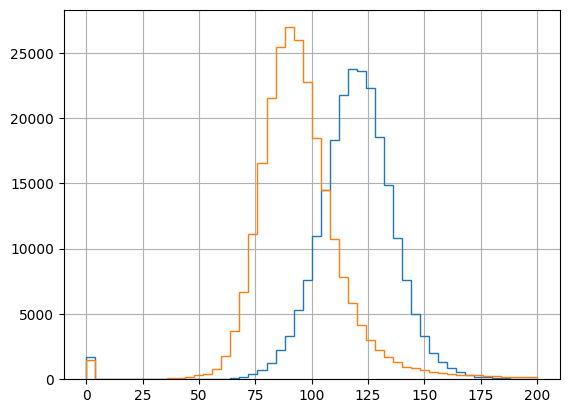

In [2]:
# label,weight,mva_random_number,n_electrons,n_jets,n_jets_30,n_jets_40,n_muons,n_taus,tau_0_p4.Pt,tau_0_p4.Eta,tau_0_p4.Phi,tau_1_p4.Pt,tau_1_p4.Eta,tau_1_p4.Phi,ditau_deta,ditau_dphi,ditau_dr,ditau_higgspt,ditau_mmc_mlm_m,ditau_scal_sum_pt,jet_0_p4.Pt,jet_0_p4.Eta,jet_0_p4.Phi,jet_1_p4.Pt,jet_1_p4.Eta,jet_1_p4.Phi,dijet_p4.Pt,dijet_p4.Eta,dijet_p4.Phi,dijet_p4.M,dijet_dPhi,dijet_dr,jet_0_p4.Eta-jet_1_p4.Eta,pt_total,scalar_sum_pt,met_p4.Pt

import pandas as pd
dataframe = pd.read_csv('/scratch/ucjf-atlas/njsf164/data_higgs.csv')

sig_dataframe = dataframe[ dataframe['label'] == 1  ]
bkg_dataframe = dataframe[ dataframe['label'] == 0  ]

sig_dataframe['ditau_mmc_mlm_m'].hist(bins=50, range=(0,200), histtype='step', label='Signal')
bkg_dataframe['ditau_mmc_mlm_m'].hist(bins=50, range=(0,200), histtype='step', label='Bkg')

print(len(sig_dataframe))
print(len(bkg_dataframe))



In [3]:
variables = [
  'tau_0_p4.Pt',
  'tau_0_p4.Eta',
  'tau_0_p4.Phi',
  'tau_1_p4.Pt',
  'tau_1_p4.Eta',
  'tau_1_p4.Phi',
  'jet_0_p4.Pt',
  'jet_0_p4.Eta',
  'jet_0_p4.Phi',
  'jet_1_p4.Pt',
  'jet_1_p4.Eta',
  'jet_1_p4.Phi',
  'ditau_deta',
  'ditau_dphi',
  'ditau_dr',
  'ditau_higgspt',
  'ditau_mmc_mlm_m',
  'dijet_p4.Pt',
  'dijet_p4.M',
  'met_p4.Pt',
  'n_jets',
  'n_jets_30',
  'n_jets_40',
  'n_muons',
  'n_electrons',
  'n_taus',
]

sig_dataframe_sel = sig_dataframe[variables].to_numpy()
bkg_dataframe_sel = bkg_dataframe[variables].to_numpy()

sig_dataframe_label = sig_dataframe['label'].to_numpy()
bkg_dataframe_label = bkg_dataframe['label'].to_numpy()

# add to the dataset
dataset_sig = tf.data.Dataset.from_tensor_slices( (sig_dataframe_sel, sig_dataframe_label) )
dataset_bkg = tf.data.Dataset.from_tensor_slices( (bkg_dataframe_sel, bkg_dataframe_label) )

# dataset = tf.data.Dataset.from_tensor_slices( (dataframe[variables].to_numpy(), dataframe['label'].to_numpy()) )

dataset = tf.data.Dataset.sample_from_datasets([dataset_sig, dataset_bkg], [0.5, 0.5], stop_on_empty_dataset=True)

batch_size = 1024
dataset_batched = dataset.batch(batch_size)

for x in dataset_batched.take(1):
    print(x)

# split the dataset into training and validation
n_train = int(0.8 * len(dataframe))
n_val = len(dataframe) - n_train

dataset_train = dataset_batched.take(n_train//batch_size)
dataset_val = dataset_batched.skip(n_train//batch_size)

(<tf.Tensor: shape=(1024, 26), dtype=float64, numpy=
array([[101.184   ,  -0.388817,   2.86892 , ...,   1.      ,   0.      ,
          1.      ],
       [ 74.7268  ,   1.124   ,   2.92221 , ...,   1.      ,   1.      ,
          0.      ],
       [ 71.2194  ,  -0.569922,  -0.450067, ...,   0.      ,   0.      ,
          2.      ],
       ...,
       [ 56.6415  ,  -1.10455 ,  -1.66083 , ...,   0.      ,   0.      ,
          2.      ],
       [ 65.8255  ,  -1.91543 ,   2.02523 , ...,   0.      ,   1.      ,
          1.      ],
       [ 95.3743  ,  -0.941316,  -1.395   , ...,   1.      ,   0.      ,
          1.      ]])>, <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([1, 0, 1, ..., 1, 0, 1])>)


In [4]:
## Building the model

# normalizer
def pick_data( data, label ):
    return data

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(dataset_train.map(pick_data))

HIDDEN_LAYER_SIZE = 100
N_LAYERS = 4

# 1. define the input and output layer
input = tf.keras.layers.Input(shape=(len(variables),) )
layer = normalizer(input)
for i in range(N_LAYERS):
  layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE//N_LAYERS, activation='relu')(layer)

layer = tf.keras.layers.Dense(1, activation='sigmoid')(layer)

model = tf.keras.models.Model(inputs=input, outputs=layer)

# learning rate decay
initial_learning_rate = 0.001
N_EPOCHS = 10
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = N_EPOCHS * n_train // batch_size,
    alpha = 0.01 * initial_learning_rate)

# 2. compile the model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=[tf.metrics.BinaryAccuracy(), tf.metrics.Recall(), tf.metrics.Precision()]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 26)             │            53 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704 (10.57 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 53 (216.00 B)

In [5]:
# trainig the model

history = model.fit(dataset_train, validation_data=dataset_val, epochs=N_EPOCHS)


Epoch 1/10


I0000 00:00:1733305019.663772  323631 service.cc:146] XLA service 0x7f1ec80050f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733305019.663800  323631 service.cc:154]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9


     23/Unknown 4s 7ms/step - binary_accuracy: 0.5256 - loss: 0.6979 - precision: 0.5151 - recall: 0.9660

I0000 00:00:1733305022.327180  323631 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    365/Unknown 6s 8ms/step - binary_accuracy: 0.7571 - loss: 0.4866 - precision: 0.7345 - recall: 0.8404

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - binary_accuracy: 0.7573 - loss: 0.4864 - precision: 0.7347 - recall: 0.8404 - val_binary_accuracy: 0.8648 - val_loss: 0.3146 - val_precision: 0.8547 - val_recall: 0.8764
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - binary_accuracy: 0.8675 - loss: 0.3088 - precision: 0.8618 - recall: 0.8761 - val_binary_accuracy: 0.8713 - val_loss: 0.2974 - val_precision: 0.8640 - val_recall: 0.8789
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8742 - loss: 0.2951 - precision: 0.8693 - recall: 0.8814 - val_binary_accuracy: 0.8743 - val_loss: 0.2914 - val_precision: 0.8675 - val_recall: 0.8811
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8770 - loss: 0.2891 - precision: 0.8722 - recall: 0.8841 - val_binary_accuracy: 0.8754 - val_loss: 0.2883 - val_precision: 0.8735 - val_recall: 0.8757
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.8787 - loss: 0.2855 - precision: 0.8

dict_keys(['binary_accuracy', 'loss', 'precision', 'recall', 'val_binary_accuracy', 'val_loss', 'val_precision', 'val_recall'])


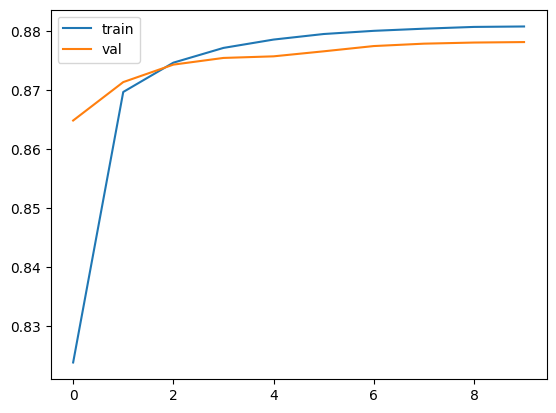

In [6]:
# draw some plots
# history of the training
import matplotlib.pyplot as plt

print(history.history.keys())

plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.legend()

plt.show()

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


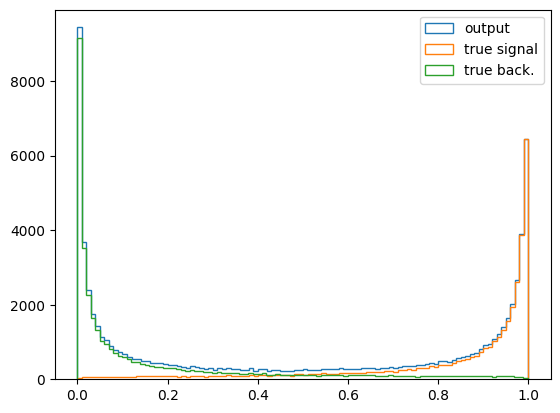

In [7]:
import matplotlib.pyplot as plt

def pick_data( data, label ):
    return data

def filter_sig( data, label ):
    return label == 1

def filter_bkg( data, label ):
    return label == 0

# unbatch the dataset
dataset_val_unbatched = dataset_val.unbatch()

# filter signal and background events
dataset_val_sig = dataset_val_unbatched.filter( filter_sig ).batch(batch_size)
dataset_val_bkg = dataset_val_unbatched.filter( filter_bkg ).batch(batch_size)

# pick just data events from dataset_val
dataset_val_data = dataset_val.map( pick_data )
dataset_val_sig_data = dataset_val_sig.map( pick_data )
dataset_val_bkg_data = dataset_val_bkg.map( pick_data )


# for x in dataset_val_unbatched.take(1):
#     print(x)

# predict the output
y = model.predict(dataset_val_data)
y_sig = model.predict(dataset_val_sig_data)
y_bkg = model.predict(dataset_val_bkg_data)


# plot the output
plt.hist(y, bins=100, histtype='step', label='output')
plt.hist(y_sig, bins=100, histtype='step', label='true signal')
plt.hist(y_bkg, bins=100, histtype='step', label='true back.')
plt.legend()